[View in Colaboratory](https://colab.research.google.com/github/nachotp/Tarea2-INF395/blob/master/Tarea_2.ipynb)

<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 2 - Redes Neuronales Convolucionales y Recurrentes </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Regularización en Redes Convolucionales.
* Diseño e implementación de redes recurrentes (RNN) usando keras.
* Diseño y entrenamiento de autoencoders (AEs)
* Transfer Learning, pre-entrenamiento (*fine tunning*).
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 1 y 4 de Junio.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea2-INF395-I-2018]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Entrenamiento de RNNs en una Serie de Tiempo    
[2.](#segundo) Redes recurrentes sobre texto  
[3.](#tercero) Autoencoders (AEs) en MNIST  
[4.](#cuarto) Transfer Learning

*Nota: Para esta actividad si es que no se cuenta con GPU se recomienda utilizar el entorno virtual de __[Colaboratory - Google](https://colab.research.google.com/)__*


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, CuDNNLSTM, SimpleRNN, GRU

C:\Users\thena\Redes Neuronales\rna\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5028901899020983858, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3177421209
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1001087866917091933
 physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:23:00.0, compute capability: 5.2"]

# Pregunta 1

### a) Carga de datos al kernel


In [0]:
name_f = "https://raw.githubusercontent.com/nachotp/Tarea2-INF395/master/time_series_data.csv"
dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)
dataframe[:] = dataframe[:].astype('float32')
df_train, df_test, df_val = dataframe[:1500].values, dataframe[1500:2000].values, dataframe[2000:].values

scaler = MinMaxScaler(feature_range=(0,1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)
stream_validation_scaled = scaler.transform(df_val)

In [4]:
dataframe.head()

,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
0,20.700001
1,17.900000
2,18.799999
3,14.600000
4,15.800000


### b) Ajuste de dataset para _lag_

In [0]:
def create_dataset(dataset,lag=1):
  dataX = []
  dataY = []
  dataset = dataset.flatten()
  for i in range(lag+1, len(dataset)):
    dataX.append(dataset[i-(lag+1):i-1])
    dataY.append(dataset[i])
  
  return np.array(dataX),np.array(dataY)

### c-d) Preparacion de dataset de entrenamiento

In [0]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
valX, valY = create_dataset(stream_validation_scaled, lag)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))

### e) Entrenamiento de red LSTM

In [7]:
model = Sequential()
model.add(CuDNNLSTM(4, input_shape=(1, lag)))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
lstm_results = model.fit(trainX, trainY, epochs=25, batch_size=1, validation_data=(valX, valY), verbose=2);

Train on 1496 samples, validate on 1646 samples
Epoch 1/25
 - 11s - loss: 0.0270 - val_loss: 0.0136
Epoch 2/25
 - 9s - loss: 0.0150 - val_loss: 0.0130
Epoch 3/25
 - 10s - loss: 0.0147 - val_loss: 0.0128
Epoch 4/25
 - 10s - loss: 0.0146 - val_loss: 0.0126
Epoch 5/25
 - 10s - loss: 0.0144 - val_loss: 0.0141
Epoch 6/25
 - 10s - loss: 0.0145 - val_loss: 0.0125
Epoch 7/25
 - 9s - loss: 0.0145 - val_loss: 0.0125
Epoch 8/25
 - 10s - loss: 0.0144 - val_loss: 0.0124
Epoch 9/25
 - 10s - loss: 0.0146 - val_loss: 0.0124
Epoch 10/25
 - 10s - loss: 0.0146 - val_loss: 0.0125
Epoch 11/25
 - 9s - loss: 0.0144 - val_loss: 0.0125
Epoch 12/25
 - 9s - loss: 0.0144 - val_loss: 0.0124
Epoch 13/25
 - 9s - loss: 0.0145 - val_loss: 0.0124
Epoch 14/25
 - 9s - loss: 0.0145 - val_loss: 0.0125
Epoch 15/25
 - 10s - loss: 0.0145 - val_loss: 0.0127
Epoch 16/25
 - 9s - loss: 0.0144 - val_loss: 0.0129
Epoch 17/25
 - 10s - loss: 0.0145 - val_loss: 0.0139
Epoch 18/25
 - 9s - loss: 0.0145 - val_loss: 0.0125
Epoch 19/25
 - 

### f-h) Predicciones y gráficos con el modelo

In [8]:
trainPredict = model.predict(trainX, batch_size=1)
testPredict = model.predict(testX, batch_size=1)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

trainYre = trainY.reshape(-1,1)
trainYre = scaler.inverse_transform(trainYre)
testYre = testY.reshape(-1,1)
testYre = scaler.inverse_transform(testYre)
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainYre, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testYre, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.14 RMSE
Test Score: 2.88 RMSE


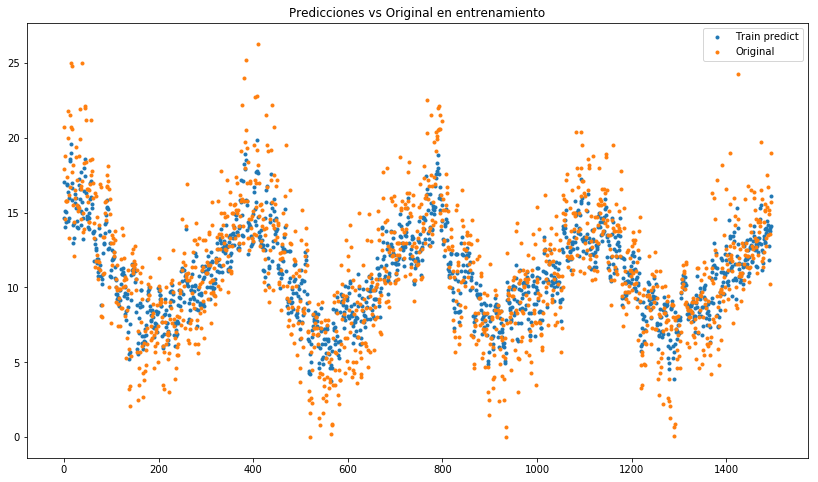

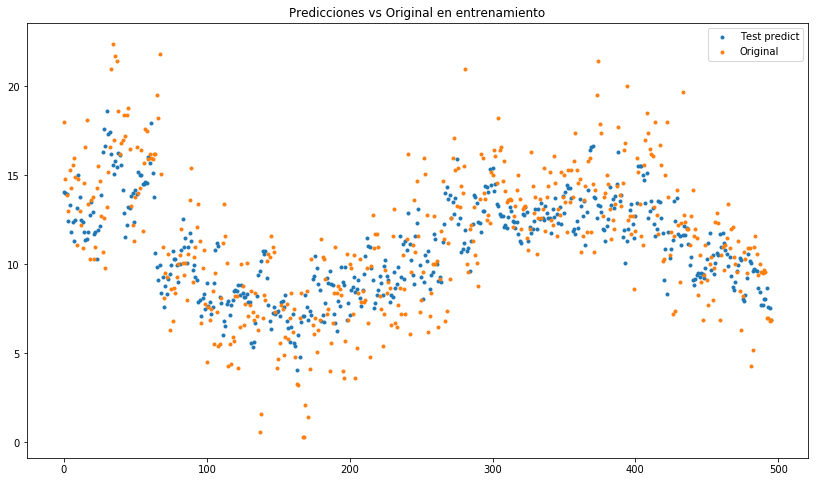

In [10]:
# shift train predictions for plotting
trainPredictPlot = trainPredict.flatten()
# shift test predictions for plotting
testPredictPlot = testPredict.flatten()
X = range(1496)
plt.figure(1, figsize=(14,8))
plt.scatter(X, trainPredictPlot, marker=".", label = "Train predict")
plt.scatter(X, dataframe.values.flatten()[:1496], marker=".", label= "Original")
plt.title("Predicciones vs Original en entrenamiento")
plt.legend();

X = range(496)
plt.figure(2, figsize=(14,8))
plt.scatter(X, testPredictPlot, marker=".", label = "Test predict")
plt.scatter(X, dataframe.values.flatten()[1496:1496+496], marker=".", label= "Original")
plt.title("Predicciones vs Original en entrenamiento")
plt.legend();


### i) Train con timestep de 3

In [91]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
valX, valY = create_dataset(stream_validation_scaled, lag)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
valX = np.reshape(valX, (valX.shape[0], valX.shape[1], 1))
model = Sequential()
model.add(CuDNNLSTM(4, input_shape=(lag ,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
t3_lstm_results = model.fit(trainX, trainY, epochs=25, batch_size=1, validation_data=(valX, valY), verbose=2)

Train on 1496 samples, validate on 1646 samples
Epoch 1/25
 - 12s - loss: 0.0158 - val_loss: 0.0131
Epoch 2/25
 - 11s - loss: 0.0149 - val_loss: 0.0127
Epoch 3/25
 - 11s - loss: 0.0149 - val_loss: 0.0127
Epoch 4/25
 - 11s - loss: 0.0151 - val_loss: 0.0134
Epoch 5/25
 - 11s - loss: 0.0150 - val_loss: 0.0129
Epoch 6/25
 - 12s - loss: 0.0148 - val_loss: 0.0127
Epoch 7/25
 - 11s - loss: 0.0149 - val_loss: 0.0130
Epoch 8/25
 - 11s - loss: 0.0148 - val_loss: 0.0135
Epoch 9/25
 - 11s - loss: 0.0147 - val_loss: 0.0127
Epoch 10/25
 - 11s - loss: 0.0149 - val_loss: 0.0130
Epoch 11/25
 - 11s - loss: 0.0148 - val_loss: 0.0128
Epoch 12/25
 - 11s - loss: 0.0148 - val_loss: 0.0127
Epoch 13/25
 - 11s - loss: 0.0149 - val_loss: 0.0129
Epoch 14/25
 - 11s - loss: 0.0148 - val_loss: 0.0127
Epoch 15/25
 - 11s - loss: 0.0148 - val_loss: 0.0134
Epoch 16/25
 - 11s - loss: 0.0149 - val_loss: 0.0127
Epoch 17/25
 - 11s - loss: 0.0146 - val_loss: 0.0126
Epoch 18/25
 - 11s - loss: 0.0148 - val_loss: 0.0129
Epoch 1

Predicciones del modelo con timestep 3:

In [92]:
trainPredict = model.predict(trainX, batch_size=1)
testPredict = model.predict(testX, batch_size=1)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

trainYre = trainY.reshape(-1,1)
trainYre = scaler.inverse_transform(trainYre)
testYre = testY.reshape(-1,1)
testYre = scaler.inverse_transform(testYre)
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainYre, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testYre, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.23 RMSE
Test Score: 2.98 RMSE


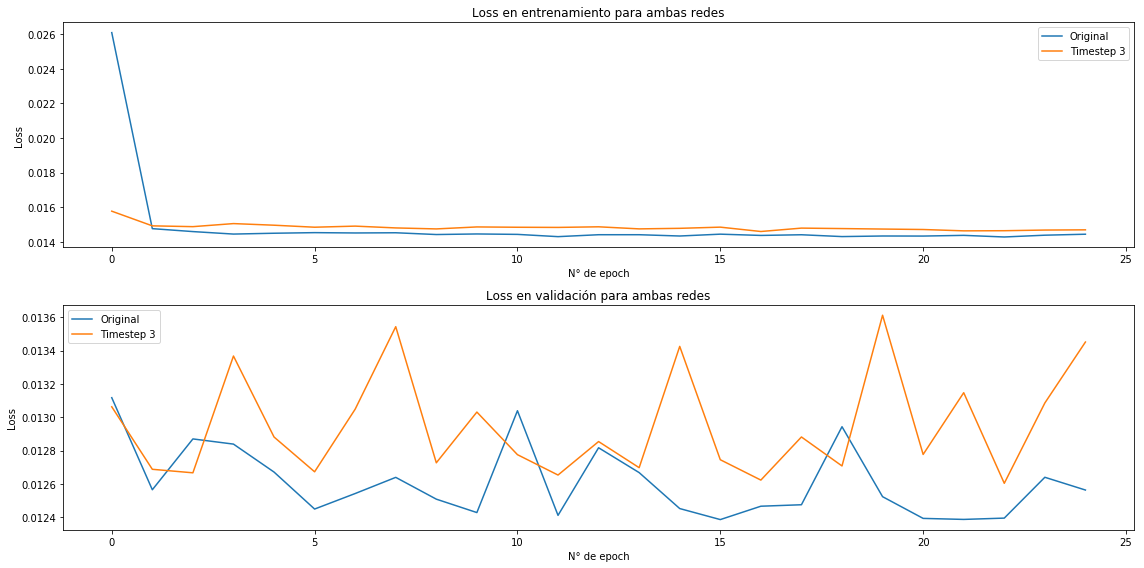

In [96]:
plt.figure(1, figsize=(16,8))
plt.subplot(211)
plt.title("Loss en entrenamiento para ambas redes")
plt.plot(lstm_results.history['loss'], label = "Original")
plt.plot(t3_lstm_results.history['loss'], label="Timestep 3")
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()

plt.subplot(212)
plt.title("Loss en validación para ambas redes")
plt.plot(lstm_results.history['val_loss'], label = "Original")
plt.plot(t3_lstm_results.history['val_loss'], label="Timestep 3")
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()

plt.tight_layout()
plt.show();

Los cálculos de RMSE y los gráficos anteriores muestran que la red original implementada en **(e)** dio mejores resultados que la RNN con timestep de 3, se puede ver que el loss de validación no converge para la red de Timestep 3 mientras que la anterior tiene un comportamiento levemente más descendiente y con valores más bajos.

### j) Variación de tamaño de bloques para LSTM

In [104]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
valX, valY = create_dataset(stream_validation_scaled, lag)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))


block_loss = []
block_val_loss = []
nb = range(4,13,2)
for blocks in nb:
  model = Sequential()
  model.add(CuDNNLSTM(blocks,input_shape=(1, lag)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  print("Entrenando LSTM con {0} bloques.".format(blocks))
  result = model.fit(trainX, trainY, epochs=25, batch_size=1, validation_data=(valX, valY), verbose=0);
  block_loss.append(result.history['loss'])
  block_val_loss.append(result.history['val_loss'])

Entrenando LSTM con 4 bloques.
Entrenando LSTM con 6 bloques.
Entrenando LSTM con 8 bloques.
Entrenando LSTM con 10 bloques.
Entrenando LSTM con 12 bloques.


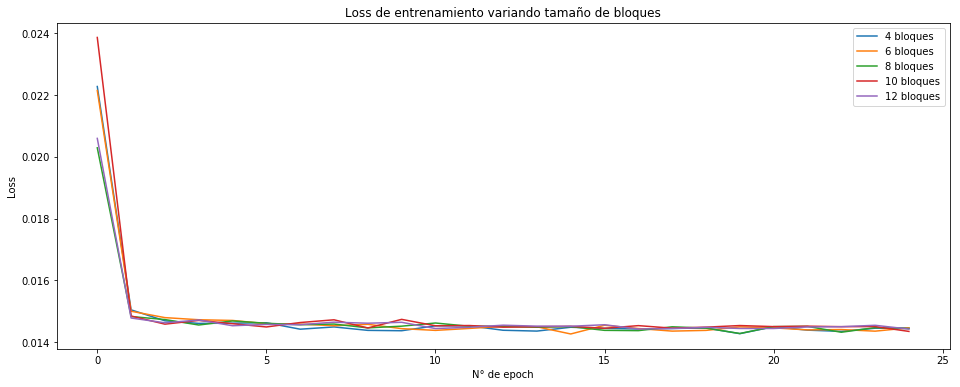

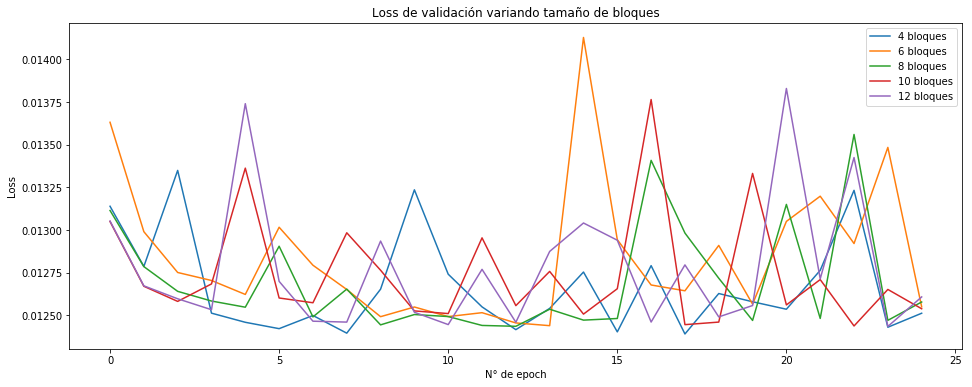

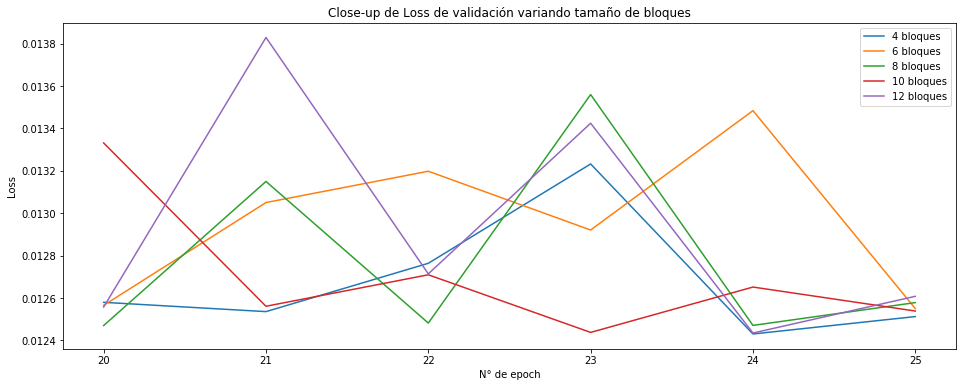

In [109]:
plt.figure(1, figsize=(16,6))
plt.title("Loss de entrenamiento variando tamaño de bloques")
for i in range(len(nb)):
  plt.plot(
      block_loss[i], label="{0} bloques".format(nb[i]))
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.show();

plt.figure(1, figsize=(16,6))
plt.title("Loss de validación variando tamaño de bloques")
for i in range(len(nb)):
  plt.plot(
      block_val_loss[i], label="{0} bloques".format(nb[i]))
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.show();

plt.figure(1, figsize=(16,6))
plt.title("Close-up de Loss de validación variando tamaño de bloques")
for i in range(len(nb)):
  plt.plot(range(20,26), block_val_loss[i][19:], label="{0} bloques".format(nb[i]))
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.show();

De los resultados obtenidos, se puede ver que de todos los tamaños de bloque utilizados, el que entrega un  menor _loss_ es 4 bloques y de manera cualitativa, tiene un comportamiento menos errático que el resto al presentar alzas más bajas a medida que avanzan los epochs.

### k) Variación de lag para LSTM

In [7]:
lag_loss = []
lag_val_loss = []

for lag in range(1,5):
  trainX, trainY = create_dataset(stream_train_scaled, lag)
  testX, testY = create_dataset(stream_test_scaled, lag)
  valX, valY = create_dataset(stream_validation_scaled, lag)

  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
  valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))
  
  model = Sequential()
  model.add(CuDNNLSTM(4, input_shape=(1, lag)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  print("Entrenando LSTM con lag {0}.".format(lag))
  result = model.fit(trainX, trainY, epochs=25, batch_size=1, validation_data=(valX, valY), verbose=0);
  lag_loss.append(result.history['loss'])
plt.figure(1, figsize=(16,6))
plt.title("Loss de validación variando tamaño de lag")
for i in range(1,5):
  plt.plot(lag_val_loss[i-1], label="lag: {0}".format(i))
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.show();  lag_val_loss.append(result.history['val_loss'])

Entrenando LSTM con lag 1.
Entrenando LSTM con lag 2.
Entrenando LSTM con lag 3.
Entrenando LSTM con lag 4.


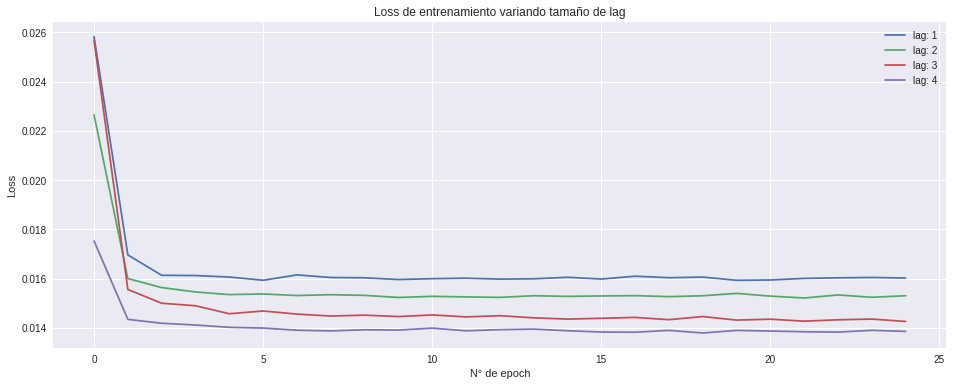

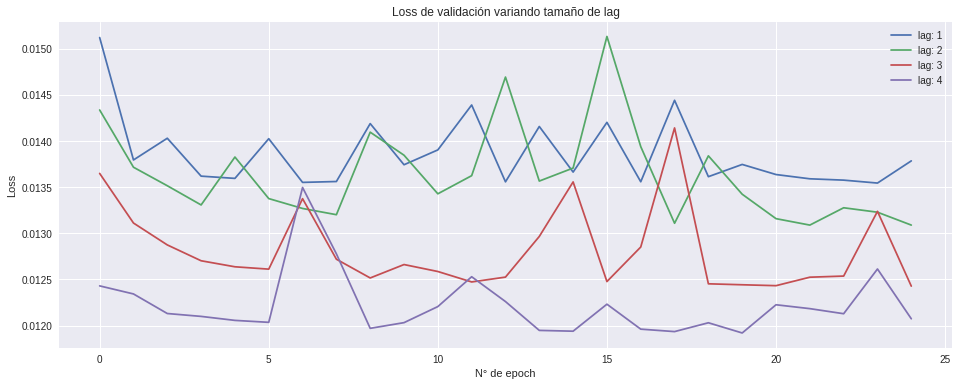

In [11]:
plt.figure(1, figsize=(16,6))
plt.title("Loss de entrenamiento variando tamaño de lag")
for i in range(1,5):
  plt.plot(lag_loss[i-1], label="lag: {0}".format(i))
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.show();

plt.figure(1, figsize=(16,6))
plt.title("Loss de validación variando tamaño de lag")
for i in range(1,5):
  plt.plot(lag_val_loss[i-1], label="lag: {0}".format(i))
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.show();

### l) comparación entre LSTM, GRU, y Red Recurrente Simple

In [11]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
valX, valY = create_dataset(stream_validation_scaled, lag)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))

model = Sequential()
model.add(CuDNNLSTM(4, input_shape=(1, lag)))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
lstm_results = model.fit(trainX, trainY, epochs=25, batch_size=1, validation_data=(valX, valY), verbose=2);

Train on 1496 samples, validate on 1646 samples
Epoch 1/25
 - 9s - loss: 0.0293 - val_loss: 0.0130
Epoch 2/25
 - 9s - loss: 0.0148 - val_loss: 0.0126
Epoch 3/25
 - 9s - loss: 0.0146 - val_loss: 0.0126
Epoch 4/25
 - 9s - loss: 0.0145 - val_loss: 0.0127
Epoch 5/25
 - 9s - loss: 0.0145 - val_loss: 0.0126
Epoch 6/25
 - 9s - loss: 0.0144 - val_loss: 0.0147
Epoch 7/25
 - 9s - loss: 0.0143 - val_loss: 0.0126
Epoch 8/25
 - 9s - loss: 0.0145 - val_loss: 0.0125
Epoch 9/25
 - 9s - loss: 0.0144 - val_loss: 0.0124
Epoch 10/25
 - 9s - loss: 0.0144 - val_loss: 0.0130
Epoch 11/25
 - 9s - loss: 0.0143 - val_loss: 0.0124
Epoch 12/25
 - 9s - loss: 0.0145 - val_loss: 0.0132
Epoch 13/25
 - 9s - loss: 0.0144 - val_loss: 0.0130
Epoch 14/25
 - 9s - loss: 0.0144 - val_loss: 0.0124
Epoch 15/25
 - 9s - loss: 0.0143 - val_loss: 0.0125
Epoch 16/25
 - 9s - loss: 0.0144 - val_loss: 0.0124
Epoch 17/25
 - 9s - loss: 0.0144 - val_loss: 0.0127
Epoch 18/25
 - 9s - loss: 0.0144 - val_loss: 0.0125
Epoch 19/25
 - 9s - loss:

In [15]:
model = Sequential()
model.add(GRU(4,input_shape=(1, lag), inner_init='orthogonal', activation='tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
gru_results = model.fit(trainX, trainY, epochs=25, batch_size=1, validation_data=(valX, valY), verbose=2)

C:\Users\thena\Redes Neuronales\rna\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(4, input_shape=(1, 3), activation="tanh", recurrent_initializer="orthogonal")`
  


Train on 1496 samples, validate on 1646 samples
Epoch 1/25
 - 10s - loss: 0.0257 - val_loss: 0.0132
Epoch 2/25
 - 10s - loss: 0.0148 - val_loss: 0.0128
Epoch 3/25
 - 10s - loss: 0.0146 - val_loss: 0.0128
Epoch 4/25
 - 10s - loss: 0.0146 - val_loss: 0.0126
Epoch 5/25
 - 10s - loss: 0.0145 - val_loss: 0.0133
Epoch 6/25
 - 10s - loss: 0.0145 - val_loss: 0.0128
Epoch 7/25
 - 10s - loss: 0.0146 - val_loss: 0.0129
Epoch 8/25
 - 10s - loss: 0.0144 - val_loss: 0.0126
Epoch 9/25
 - 10s - loss: 0.0145 - val_loss: 0.0127
Epoch 10/25
 - 9s - loss: 0.0144 - val_loss: 0.0128
Epoch 11/25
 - 9s - loss: 0.0145 - val_loss: 0.0125
Epoch 12/25
 - 9s - loss: 0.0145 - val_loss: 0.0125
Epoch 13/25
 - 9s - loss: 0.0145 - val_loss: 0.0126
Epoch 14/25
 - 10s - loss: 0.0145 - val_loss: 0.0129
Epoch 15/25
 - 9s - loss: 0.0145 - val_loss: 0.0125
Epoch 16/25
 - 10s - loss: 0.0145 - val_loss: 0.0126
Epoch 17/25
 - 9s - loss: 0.0144 - val_loss: 0.0126
Epoch 18/25
 - 9s - loss: 0.0144 - val_loss: 0.0127
Epoch 19/25
 -

In [16]:
model = Sequential()
model.add(SimpleRNN(4, input_shape=(1, lag), inner_init='orthogonal', activation='tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
simplernn_results = model.fit(trainX, trainY, epochs=25, batch_size=1, validation_data=(valX, valY), verbose=2)

C:\Users\thena\Redes Neuronales\rna\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(4, input_shape=(1, 3), activation="tanh", recurrent_initializer="orthogonal")`
  


Train on 1496 samples, validate on 1646 samples
Epoch 1/25
 - 8s - loss: 0.0386 - val_loss: 0.0191
Epoch 2/25
 - 7s - loss: 0.0191 - val_loss: 0.0148
Epoch 3/25
 - 7s - loss: 0.0160 - val_loss: 0.0132
Epoch 4/25
 - 7s - loss: 0.0149 - val_loss: 0.0127
Epoch 5/25
 - 7s - loss: 0.0147 - val_loss: 0.0140
Epoch 6/25
 - 7s - loss: 0.0148 - val_loss: 0.0127
Epoch 7/25
 - 7s - loss: 0.0148 - val_loss: 0.0124
Epoch 8/25
 - 7s - loss: 0.0147 - val_loss: 0.0124
Epoch 9/25
 - 7s - loss: 0.0146 - val_loss: 0.0124
Epoch 10/25
 - 7s - loss: 0.0146 - val_loss: 0.0125
Epoch 11/25
 - 7s - loss: 0.0146 - val_loss: 0.0126
Epoch 12/25
 - 7s - loss: 0.0146 - val_loss: 0.0127
Epoch 13/25
 - 7s - loss: 0.0146 - val_loss: 0.0131
Epoch 14/25
 - 7s - loss: 0.0147 - val_loss: 0.0124
Epoch 15/25
 - 7s - loss: 0.0146 - val_loss: 0.0124
Epoch 16/25
 - 7s - loss: 0.0147 - val_loss: 0.0125
Epoch 17/25
 - 7s - loss: 0.0147 - val_loss: 0.0125
Epoch 18/25
 - 7s - loss: 0.0146 - val_loss: 0.0131
Epoch 19/25
 - 7s - loss:

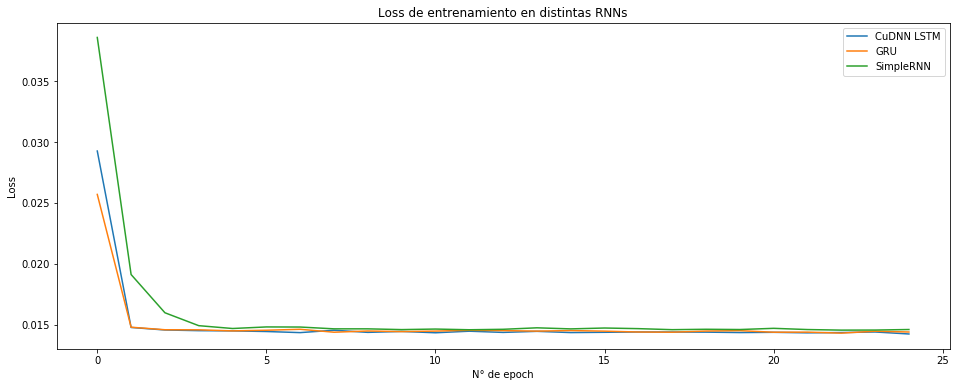

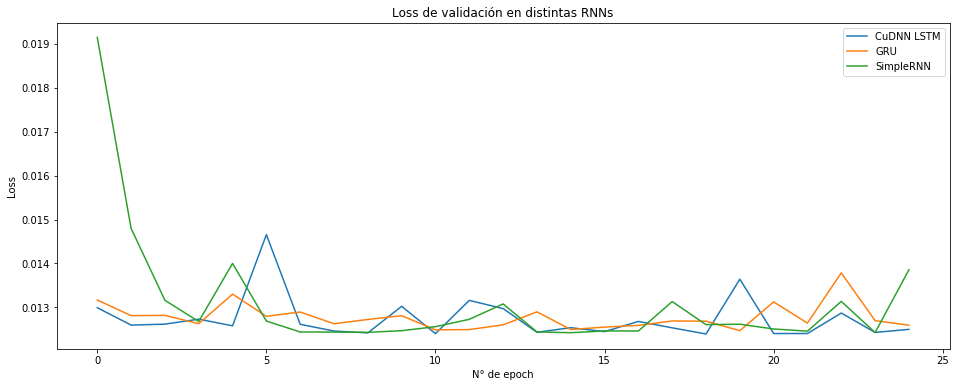

In [18]:
plt.figure(1, figsize=(16,6))
plt.title("Loss de entrenamiento en distintas RNNs")
plt.plot(lstm_results.history['loss'], label="CuDNN LSTM")
plt.plot(gru_results.history['loss'], label="GRU")
plt.plot(simplernn_results.history['loss'], label="SimpleRNN")
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.show();

plt.figure(1, figsize=(16,6))
plt.title("Loss de validación en distintas RNNs")
plt.plot(lstm_results.history['val_loss'], label="CuDNN LSTM")
plt.plot(gru_results.history['val_loss'], label="GRU")
plt.plot(simplernn_results.history['val_loss'], label="SimpleRNN")
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()
plt.show();

De los gráficos anteriores, se puede ver que la implementación con SimpleRNN es la que peor rindió en términos de loss, eso sí, fue la que más rápido ejecutó: 177 \[s\].

Al comprar CuDNN LSTM y GRU, las cuales tardaron 221 y 240.8 segundos respectivamente, se ve que ambas tienen comprotamientos y resultados similares, la red implementada con LSTM tiene un valor de loss marginalmente más bajo que GRU pero durante el entrenamiento se ve que la pérdida de validación tiene un comportamiento un poco más errático que GRU.


### m) red con memoria entre batches

In [21]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
valX, valY = create_dataset(stream_validation_scaled, lag)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
valX = np.reshape(valX, (valX.shape[0], valX.shape[1], 1))

batch_size = 1
model = Sequential()
model.add(CuDNNLSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(25):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

Epoch 1/1
 - 7s - loss: 0.0142
Epoch 1/1
 - 7s - loss: 0.0128
Epoch 1/1
 - 7s - loss: 0.0135
Epoch 1/1
 - 7s - loss: 0.0141
Epoch 1/1
 - 7s - loss: 0.0143
Epoch 1/1
 - 7s - loss: 0.0143
Epoch 1/1
 - 7s - loss: 0.0142
Epoch 1/1
 - 7s - loss: 0.0141
Epoch 1/1
 - 7s - loss: 0.0140
Epoch 1/1
 - 7s - loss: 0.0139
Epoch 1/1
 - 7s - loss: 0.0139
Epoch 1/1
 - 7s - loss: 0.0138
Epoch 1/1
 - 7s - loss: 0.0138
Epoch 1/1
 - 7s - loss: 0.0137
Epoch 1/1
 - 7s - loss: 0.0137
Epoch 1/1
 - 7s - loss: 0.0137
Epoch 1/1
 - 7s - loss: 0.0136
Epoch 1/1
 - 7s - loss: 0.0136
Epoch 1/1
 - 7s - loss: 0.0136
Epoch 1/1
 - 7s - loss: 0.0136
Epoch 1/1
 - 7s - loss: 0.0135
Epoch 1/1
 - 7s - loss: 0.0135
Epoch 1/1
 - 7s - loss: 0.0135
Epoch 1/1
 - 7s - loss: 0.0135
Epoch 1/1
 - 7s - loss: 0.0135


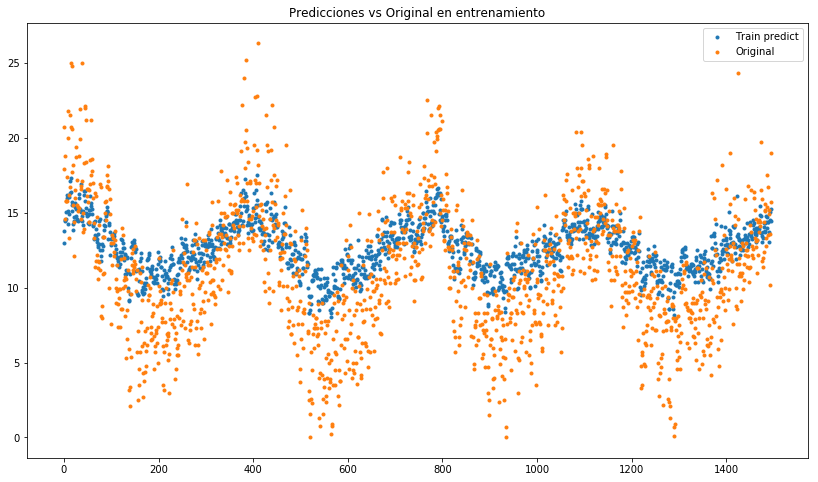

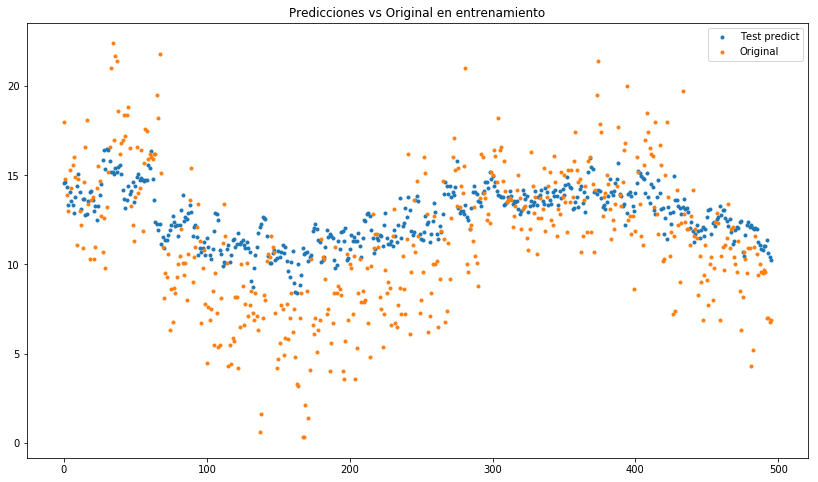

In [22]:
trainPredict = model.predict(trainX, batch_size=1)
testPredict = model.predict(testX, batch_size=1)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# shift train predictions for plotting
trainPredictPlot = trainPredict.flatten()
# shift test predictions for plotting
testPredictPlot = testPredict.flatten()
X = range(1496)
plt.figure(1, figsize=(14,8))
plt.scatter(X, trainPredictPlot, marker=".", label = "Train predict")
plt.scatter(X, dataframe.values.flatten()[:1496], marker=".", label= "Original")
plt.title("Predicciones vs Original en entrenamiento")
plt.legend();

X = range(496)
plt.figure(2, figsize=(14,8))
plt.scatter(X, testPredictPlot, marker=".", label = "Test predict")
plt.scatter(X, dataframe.values.flatten()[1496:1496+496], marker=".", label= "Original")
plt.title("Predicciones vs Original en entrenamiento")
plt.legend();


Claramente la red tiene un peor desempeño que la entrenada en (e)

In [7]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
valX, valY = create_dataset(stream_validation_scaled, lag)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
valX = np.reshape(valX, (valX.shape[0], valX.shape[1], 1))

batch_size = 4
model = Sequential()
model.add(CuDNNLSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(25):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

Epoch 1/1
 - 3s - loss: 0.0323
Epoch 1/1
 - 2s - loss: 0.0204
Epoch 1/1
 - 1s - loss: 0.0184
Epoch 1/1
 - 1s - loss: 0.0172
Epoch 1/1
 - 2s - loss: 0.0165
Epoch 1/1
 - 1s - loss: 0.0160
Epoch 1/1
 - 1s - loss: 0.0157
Epoch 1/1
 - 2s - loss: 0.0154
Epoch 1/1
 - 2s - loss: 0.0152
Epoch 1/1
 - 2s - loss: 0.0151
Epoch 1/1
 - 2s - loss: 0.0149
Epoch 1/1
 - 2s - loss: 0.0148
Epoch 1/1
 - 2s - loss: 0.0148
Epoch 1/1
 - 2s - loss: 0.0147
Epoch 1/1
 - 1s - loss: 0.0147
Epoch 1/1
 - 1s - loss: 0.0147
Epoch 1/1
 - 1s - loss: 0.0147
Epoch 1/1
 - 1s - loss: 0.0146
Epoch 1/1
 - 1s - loss: 0.0146
Epoch 1/1
 - 1s - loss: 0.0146
Epoch 1/1
 - 2s - loss: 0.0146
Epoch 1/1
 - 2s - loss: 0.0145
Epoch 1/1
 - 1s - loss: 0.0145
Epoch 1/1
 - 1s - loss: 0.0145
Epoch 1/1
 - 1s - loss: 0.0144


### n) Red con memoria entre batches con batch_size 4

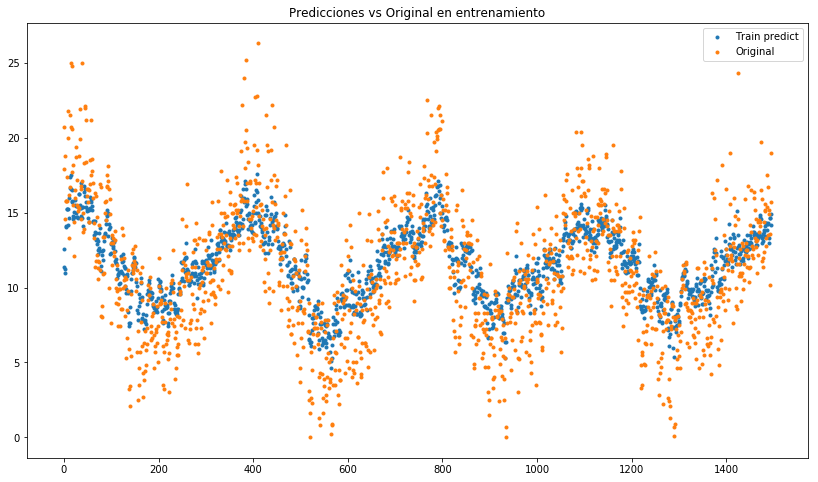

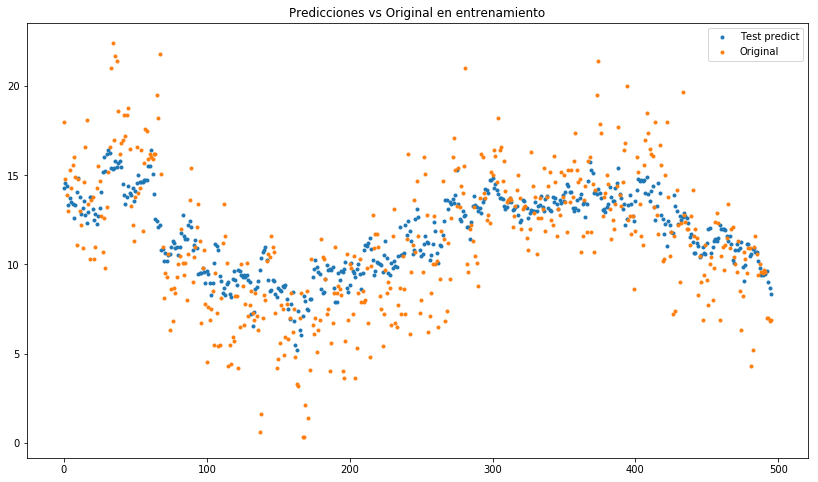

In [9]:
trainPredict = model.predict(trainX, batch_size=4)
testPredict = model.predict(testX, batch_size=4)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# shift train predictions for plotting
trainPredictPlot = trainPredict.flatten()
# shift test predictions for plotting
testPredictPlot = testPredict.flatten()
X = range(1496)
plt.figure(1, figsize=(14,8))
plt.scatter(X, trainPredictPlot, marker=".", label = "Train predict")
plt.scatter(X, dataframe.values.flatten()[:1496], marker=".", label= "Original")
plt.title("Predicciones vs Original en entrenamiento")
plt.legend();

X = range(496)
plt.figure(2, figsize=(14,8))
plt.scatter(X, testPredictPlot, marker=".", label = "Test predict")
plt.scatter(X, dataframe.values.flatten()[1496:1496+496], marker=".", label= "Original")
plt.title("Predicciones vs Original en entrenamiento")
plt.legend();

### o) LSTM Apilada

In [11]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
valX, valY = create_dataset(stream_validation_scaled, lag)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
valX = np.reshape(valX, (valX.shape[0], valX.shape[1], 1))
model = Sequential()
model.add(CuDNNLSTM(4, input_shape=(lag ,1), return_sequences=True))
model.add(CuDNNLSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
stack_lstm_results = model.fit(trainX, trainY, epochs=25, batch_size=1, validation_data=(valX, valY), verbose=2)

Train on 1496 samples, validate on 1646 samples
Epoch 1/25
 - 13s - loss: 0.0244 - val_loss: 0.0134
Epoch 2/25
 - 13s - loss: 0.0158 - val_loss: 0.0135
Epoch 3/25
 - 13s - loss: 0.0156 - val_loss: 0.0154
Epoch 4/25
 - 12s - loss: 0.0155 - val_loss: 0.0131
Epoch 5/25
 - 12s - loss: 0.0153 - val_loss: 0.0133
Epoch 6/25
 - 13s - loss: 0.0152 - val_loss: 0.0134
Epoch 7/25
 - 12s - loss: 0.0154 - val_loss: 0.0143
Epoch 8/25
 - 12s - loss: 0.0150 - val_loss: 0.0163
Epoch 9/25
 - 12s - loss: 0.0151 - val_loss: 0.0154
Epoch 10/25
 - 13s - loss: 0.0153 - val_loss: 0.0130
Epoch 11/25
 - 12s - loss: 0.0148 - val_loss: 0.0135
Epoch 12/25
 - 12s - loss: 0.0149 - val_loss: 0.0127
Epoch 13/25
 - 13s - loss: 0.0150 - val_loss: 0.0131
Epoch 14/25
 - 13s - loss: 0.0149 - val_loss: 0.0129
Epoch 15/25
 - 12s - loss: 0.0149 - val_loss: 0.0133
Epoch 16/25
 - 12s - loss: 0.0149 - val_loss: 0.0133
Epoch 17/25
 - 13s - loss: 0.0148 - val_loss: 0.0128
Epoch 18/25
 - 13s - loss: 0.0149 - val_loss: 0.0126
Epoch 1

In [12]:
trainPredict = model.predict(trainX, batch_size=1)
testPredict = model.predict(testX, batch_size=1)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

trainYre = trainY.reshape(-1,1)
trainYre = scaler.inverse_transform(trainYre)
testYre = testY.reshape(-1,1)
testYre = scaler.inverse_transform(testYre)
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainYre, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testYre, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.13 RMSE
Test Score: 2.86 RMSE


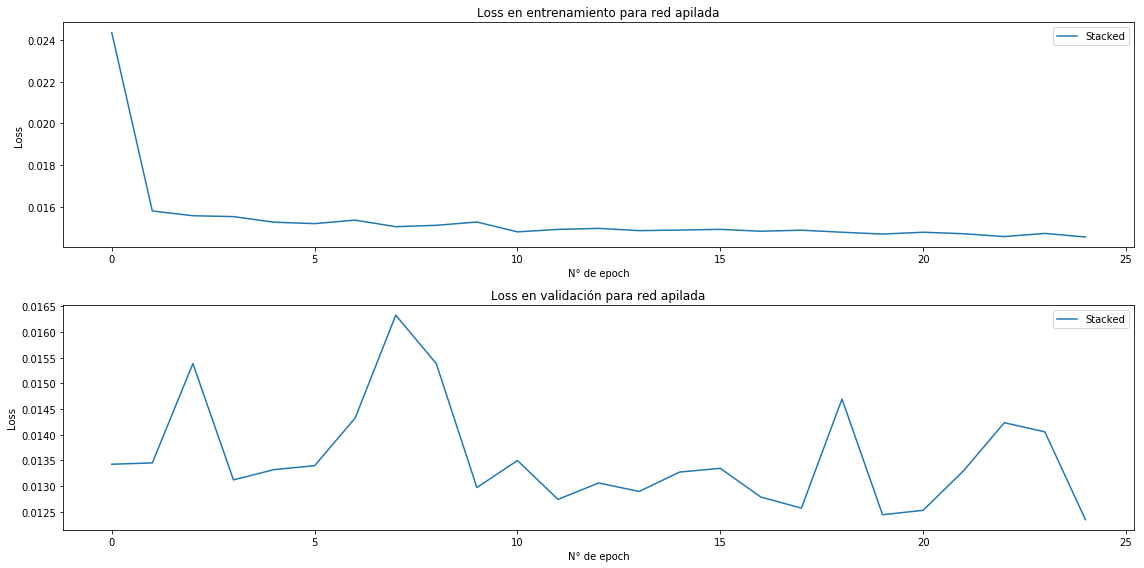

In [15]:
plt.figure(1, figsize=(16,8))
plt.subplot(211)
plt.title("Loss en entrenamiento para red apilada")
plt.plot(stack_lstm_results.history['loss'], label="Stacked")
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()

plt.subplot(212)
plt.title("Loss en validación para red apilada")
plt.plot(stack_lstm_results.history['val_loss'], label="Stacked")
plt.ylabel("Loss")
plt.xlabel("N° de epoch")
plt.legend()

plt.tight_layout()
plt.show();

La red apilada tuvo una marginal mejora a la del item **(i)**, obteniendo valores parecidos a los resultados de la red del item **(e)** tanto para las predicciones de Train y Test.

### p) valor real vs la predicción del conjunto de pruebas

<a id="segundo"></a>
# 2.  Redes recurrentes sobre texto
Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto proporcionadas por GMB (*Groningen Meaning Bank*) para reconocimiento de entidades y tagger. Trabajaremos con el dataset proprocionado a través de la interfaz de Kaggle en el siguiente __[link](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, con mas de un millón de palabras trabajaremos este dataset para realizar predicciones sobre distintas tareas, del tipo *many to many* y *many to one*.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />


Descargue los datos de la página de Kaggle y cárgelos a través de *pandas*.
```python
import numpy as np
import pandas as pd
df_ner = pd.read_csv("./entity-annotated-corpus/ner.csv", error_bad_lines=False)
df_ner.dropna(inplace=True)
```

> a) En esta primera instancia trabajaremos con la tarea de realizar un POS *tag* (*Part of Speech*) sobre cada una de las palabras en las sentencias que se nos presenta en los datos, también puede intentar el NER (*Named Entity Recogntion*) sobre la columna *tag*, esta tarea es del tipo *many to many*, es decir, la entrada es una secuencia y la salida es una secuencia sin *shift*, por lo que necesitaremos una estructura de red adecuada a esto. En primer lugar extraiga las columnas que utilizaremos del dataset ¿Por qué es conveniente utilizar *lemma* en vez de la palabra misma *word*?
```python
dataset = df_ner.loc[:,["lemma","pos","tag","prev-iob"]]
```
Luego de esto cree una estructura que contendrá todas las sentencias u oraciones y otra estructura que contendrá los *pos tagger*, esto es un arreglo de arreglos de *lemmas* y un arreglo de arreglos de *tags* respectivamente. ¿Cuales son las dimensiones de ambas estructuras? ¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?
```python
dataX,dataY = [],[]
#uniques
lemmas,labels = set(), set()
for fila in dataset.values:
    if fila[-1]=="__START1__": 
        dataX.append(np.asarray(sentence))
        dataY.append(np.asarray(labels_sentence))
        sentence= []
        label_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[1])
    sentence.append(fila[0])#add lemma
    labels_sentence.append(fila[1]) #POS o TAG
#data to  array
dataX = np.asarray(dataX[1:])
dataY = np.asarray(dataY[1:])
```    

> b) Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen
las palabras en todo el dataset. ¿Se observa una ley Zipf? ¿Cambia el resultado cuando se separan los textos de acuerdo a su clase/categorı́a? Comente.

> c) Es necesario transformar los textos para que puedan ser entregados apropiadamente a la red, por lo será necesario crear una función que codifique cada posible *lemma* a un número y cada posible *tag* a otro número, utilice esta función sobre las sentencias y *tags* ya generados. Mida cual es el largo máximo de entre todas las sentencias, la cantidad de *lemmas* y etiquetas. Además de esto, debido al largo distinto de las sentencias se deberá realizar *padding* para estandarizar el largo, considere algun carácter especial para codificar el espacio en blanco que luego se le deberá rellenar, por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" y codificado quedará como [32,4,*0, 0*].
```python
...#add fullfill lemma and tag to the dictionary
lemma2idx = {w: i for i, w in enumerate(lemmas)} #Converting text to numbers
lab2idx = {t: i for i, t in enumerate(labels)}
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]
dataY = [[lab2idx[pos] for pos in pos_tags ] for pos_tags in dataY]
n_lemmas = len(lemmas)
n_labels = len(labels)
```

> d) Realice el *padding* anteriormente mencionado, decida sobre qué le parece mas conveniente al rellenar con el valor especial ¿Al principio o al final de la sentencia? Comente
```python
from keras.preprocessing import sequence
X = sequence.pad_sequences(dataX,maxlen=max_input_lenght,padding='post' or 'pre',value=lemma2idx["yourspecialcharacter"]) 
y = sequence.pad_sequences(dataY,maxlen=max_input_lenght,padding='post' or 'pre',value=lab2idx["endtagger"])
```

> e) Para el poder entregar una clasificación sobre los distintos *pos tagger* es necesario tranformarlas a *one hot vectors*, debido a que están codificadas en números enteros, con esto se quedará con un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles *pos tags*. Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación ¿Cuáles son las dimensiones de entrada y salida de cada conjunto? Comente
```python
from keras.utils import to_categorical
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)
```

> f) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* el texto, entrenela y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *pos tag* a cada uno de estos *lemmas*, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un *output*. Como los *lemmas* corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*. Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red.
```python
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=128)
scores = model.evaluate(X_test, y_test, verbose=0)
```

> g) Varı́e la dimensionalidad del embedding inicial y determine si aumenta o disminuye el error de clasificación. Comente.

> h) Use Dropout para entrenar la LSTM. ¿El Dropout mejora el desempeño de la red? Señale cuales podrı́an ser las causas del comportamiento observado.
```python
from keras.layers import Dropout
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
model.add(LSTM(units=100,return_sequences=True)) #or recurrent_dropout=0.2
model.add(Dropout(0.2))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=128)
```

> i) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen. Mejore la red definida en f) utilizando una red neuronal recurrente Bidireccional, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas* de entrada. Comente cuál debiera ser la forma correcta de usar el parámetro *merge_mode* (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. ¿Mejora o empeora el desempeño? Analice.
```python
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_input_lenght))
layer_lstm = LSTM(units=100,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode=choose))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=128)
```

> j) Utilice alguna de las red entrenadas, ojalá una con buen desempeño y muestre las predicciones, el *pos tager*, sobre algún ejemplo de pruebas, comente. Para entender qué son los símbolos *Part of speech tags* visite el siguiente link: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html 
```python
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15}: {}".format("Lemma", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(lemmas[w],labels[pred]))
```

Ahora utilizaremos el mismo dataset para realizar una aplicación mas conocida hoy en día que es el autocompletar texto, esto es, predecir la siguiente palabra de una sentencia basada en las palabras anteriores de la misma, por lo que la red que utilizaremos es del tipo *many to one*.  
Debido a lo extenso del vocabulario es bastante complejo hacer un modelo que prediga una palabra dentro de las millones que pueden haber, por lo que, trabajaremos a nivel de carácter, en donde las posibilidades (posibles clases) son mucho menores.

> k) Carge las palabras del dataset ¿Por qué no los *lemmas*? y cree el corpus con el cual se trabajará, además de crear la codificación de caracteres a números. Esto se presenta en el código a continuación además de crear la estrucutura de los datos con los que se va a trabajar (sub sentencias del corpus original). Utilice el tamaño del *corpus* que le acomode a la memoria de su computador.
```python
dataset = df_ner.loc[:,["word","lemma"]]
text = ' '.join(dataset["word"]).lower() #corpus
null_character = "*"
chars = [null_character]+sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = {c: i for i, c in enumerate(chars)}
indices_char = {i: c for i, c in enumerate(chars)}
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 5 
sentences = []
next_chars = []
size = int(len(text)*0.2) #solo un 20% del corpus
for i in range(0, size - maxlen, step):
    sentences.append(null_character+text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))
```

> l) Procese las sentencias para así tenerlas codificadas en números que van a representar los carácteres, tal cual se realizó en c) con los *lemmas*, lo mismo para las etiquetas. Además de esto deberá realizar el *padding* correspondiente al comienzo de la sentencia, esto es para que la red aprenda cuando venga una frase mas corta de lo entrenado, este símbolo siignificará que no hay información. Transforme las etiquetas a *one hot vector* como se realizó en c) y defina la red similar a la presentada en f), con un *embedding* seguido de una capa recurrente GRU y la capa de clasificación. Aprovechese de la implementación más rápida de GRU respaldada por __[CuDNN](https://developer.nvidia.com/cudnn)__, una librería de CUDA (NVIDIA) para *Deep Neural Network*. 
```python
dataX = [[char_indices[char] for char in sentence ] for sentence in sentences]
dataY = [char_indices[char] for char in next_chars]
...#dataX pad sequence padding='pre'
...#dataY to categorical with num_classes=len(chars)
from keras.layers import CuDNNGRU,GRU
embedding_vector = 16
model = Sequential()
model.add(Embedding(input_dim=len(chars), output_dim=embedding_vector, input_length=maxlen+1))#
model.add(CuDNNGRU(units=512,return_sequences=False)) #or GRU
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
```

>  m) Entrene la red con las funciones que se presentan a continuación que mostrarán el cómo va la tarea de autocompletar texto en cada *epoch*, generando una sentencia completa de 400 carácteres *aleatoriamente* a partir de una semilla *random*. Entrene solo durante 25 *epochs*, a los 15 ya debería comenzar a generar palabras y sonar mas coherente.
```python
def predict_next_char(model, sentence, diversity=1.0):
    """Predict the next character from the current one"""    
    x_pred = [char_indices[null_character]]+[char_indices[char] for char in sentence]
    x_pred = sequence.pad_sequences([x_pred], maxlen=maxlen+1,padding='pre',value=char_indices[null_character])
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.random.choice(len(chars), p=preds)
    return indices_char[next_index]
import random,sys
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print('\n----- Generating text after Epoch: %d' % epoch)
    start_index = random.randint(0, size - maxlen - 1)
    sentence = text[start_index: start_index + maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_next_char(model, sentence0)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return
from keras.callbacks import LambdaCallback
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X, y,batch_size=256,epochs=25, callbacks=[print_callback])
```

> n) Verifique la calidad de la red entrenada, cargando el modelo si es que lo guardó o directamente, entregando una predicción sobre una semilla inicial que usted entregue. Observe y comente cualitativamente sobre qué pasa cuando la predicción del siguiente carácter fuese de manera determinista, tomando el máximo valor de entre las predicciones.
```python
sentence = "it is "
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(sentence)
for i in range(400):
    next_char = predict_next_char(model, sentence)
    sentence = sentence[1:] + next_char 
    sys.stdout.write(next_char)
    sys.stdout.flush()
```

<a id="tercero"></a>
## 3. Autoencoders (AEs) en MNIST
Como se ha discutido en clases, las RBM’s y posteriormente los AE’s (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. En esta sección aprenderemos a utilizar el más sencillo de estos modelos: un autoencoder o AE. Consideraremos tres aplicaciones clásicas: reducción de dimensionalidad, denoising y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado MNIST. Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes. La tarea consiste en construir un programa para que aprenda a identificar correctamente el dı́gito representado en la imagen


> a) Escriba una función que cargue los datos desde el repositorio de keras, normalice las imágenes de modo que los pixeles queden en [0, 1], transforme las imágenes en vectores ($\in {\rm I\!R}^{784}$) y devuelva tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. Construya el conjunto de validación utilizando los últimos $nval = 5000$ casos del conjunto del entrenamiento. El conjunto de entrenamiento consistirá en las primeras $60000 - nval$ imágenes.
```python
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255. #and x_test
#Define here your validation set
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
```

### 3.1 Reducción de dimensionalidad
Para esta primera sección se trabajará con un autoencoder tradicional (*feed forward*) en donde las capas de este son densas. Para esto se re estructuraran los datos de entradas en forma de vector, es decir la matriz de 28 $\times$ 28 pasa a ser un vector de 784 componentes.

```python
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
```

Una de las aplicaciones tı́picas de un AE es reducción de dimensionalidad, es decir, implementar una transformación $\phi:{\rm I\!R}^d \leftarrow {\rm I\!R}^{d'}$ de objetos representados originalmente por $d$ atributos en una nueva representación de $d'$ atributos, de modo tal que se preserve lo mejor posible la “información” original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadı́stico (permite construir modelos con un menor número de parámetros libres). Un AE es una técnica de reducción de dimensionalidad no supervisada porque no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento
> a) Entrene un AE básico (1 capa escondida) para generar una representación de MNIST en $d'$= 2, 8, 32, 64 dimensiones. Justifique la elección de la función de pérdida a utilizar y del criterio de entrenamiento en general. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. ¿Mejora el resultado si elegimos una función de activación **ReLU** para el Encoder? ¿Podrı́a utilizarse esta activación en el Decoder?
```python
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
input_img = Input(shape=(784,))
encoded = Dense(32, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)
autoencoder = Model(input=input_img, output=decoded)
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
##
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=50,batch_size=32,validation_data=(x_val,x_val))
autoencoder.save('basic_autoencoder_768x32.h5')
#save other stuffs
```

> b) Compare visualmente la reconstrucción que logra hacer el autoencoder desde la representación en ${\rm I\!R}^{d'}$ para algunas imágenes del conjunto de pruebas. Determine si la percepción visual se corresponde con el error de reconstrucción observada. Comente.
```python
from keras.models import load_model
autoencoder = load_model('basic_autoencoder_768x32.h5')
#load other stuff ...
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
import matplotlib
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[i].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
```

> c) Para verificar la calidad de la representación obtenida, implemente el clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $x$, el clasificador busca las k = 10 imágenes de entrenamiento más similares (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes cercanas. Mida el error de pruebas obtenido construyendo este clasificador sobre la data reducida a través del autocnder comparando con la representación reducida obtenida vía PCA (una técnica clásica de reducción de dimensionalidad) utilizando el mismo número de dimensiones $d'$= 2, 4, 8, 16, 32. Considere tanto el error de reconstrucción como el desempeño en clasificación , además de comparar los tiempos medios de predicción en ambos escenarios.
```python
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
pca = PCA(n_components=d)
#PCA
pca.fit(x_train)
pca_train = pca.transform(x_train)
pca_test = pca.transform(x_test)
#AUTOENCODER
encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)
#CLASIFICATION
clf = KNeighborsClassifier(10)
clf.fit(pca_train, y_train)
print 'Classification Accuracy PCA %.2f' % clf.score(pca_test,y_test)
clf = KNeighborsClassifier(10)
clf.fit(encoded_train, y_train)
print 'Classification Accuracy %.2f' % clf.score(encoded_test,y_test)
```

> d) Modifique el autoencoder básico construido en (a) para implementar un deep autoencoder (*deep AE*), es decir, un autoencoder con al menos dos capas ocultas. Demuestre experimentalmente que este autoencoder puede mejorar la compresión obtenida por PCA utilizando el mismo número de dimensiones $d'$ . Experimente con $d'$ =2, 4, 8, 16 y distintas profundidades (L = 2, 3, 4). Considere en esta comparación tanto el error de reconstrucción como el desempeño en clasificación (vı́a kNN) de cada representación. Comente.
```python
target_dim = 2 #try other and do a nice plot
input_img = Input(shape=(784,))
encoded1 = Dense(1000, activation='relu')(input_img)
encoded2 = Dense(500, activation='relu')(encoded1)
encoded3 = Dense(250, activation='relu')(encoded2)
encoded4 = Dense(target_dim, activation='relu')(encoded3)
decoded4 = Dense(250, activation='relu')(encoded4)
decoded3 = Dense(500, activation='relu')(encoded3)
decoded2 = Dense(1000, activation='relu')(decoded3)
decoded1 = Dense(784, activation='sigmoid')(decoded2)
autoencoder = Model(input=input_img, output=decoded1)
encoder = Model(input=input_img, output=encoded3)
autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
autoencoder.fit(x_train,x_train,epochs=40,batch_size=32,validation_data=(x_val,x_val))
autoencoder.save('my_autoencoder_768x1000x500x250x2.h5')
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
pca = PCA(n_components=target_dim)
pca.fit(x_train)
```

> e) Elija algunas de las representaciones aprendidas anteriormente y visualı́celas usando la herramienta *TSNE* disponible en la librerı́a *sklearn*. Compare cualitativamente el resultado con aquel obtenido usando PCA con el mismo número de componentes
```python
nplot=5000 #warning: mind your memory!
encoded_train = encoder.predict(x_train[:nplot])
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
encoded_train = model.fit_transform(encoded_train)
plt.figure(figsize=(10, 10))
colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
for idx in xrange(0,nplot):
    label = y_train[idx]
    line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=6)
pca_train = pca.transform(x_train)
encoded_train = pca_train[:nplot]
... #plot PCA
```

> f) Modifique el autoencoder construido en (a) para trabajar directamente sobre las imágenes de MNIST, sin tratarlas como vectores de 784 atributos, sino como matrices de tamaño $1\times28\times28$. Es posible lograr este objetivo utilizando capas convolucionales para definir el Encoder y el Decoder, comente como sufre las transformaciones el patrón de entrada. Compare la calidad de la representación reducida obtenida por el nuevo autoencoder con aquella obtenida anteriormente utilizando el mismo número de dimensiones. Comente.
```python
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) #modify for th dim ordering
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
input_img = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()
```

### 3.2 Denoising
Como se ha discutido en clases, un denoising autoencoder (dAE) es esencialmente un autoencoder entrenado para reconstruir ejemplos parcialmente corruptos. Varios autores han demostrado que mediante esta modificación simple es posible obtener representaciones más robustas y significativas que aquellas obtenidas por un AE básico. En esta sección exploraremos la aplicación más “natural” o “directa” del método.

> a) Genere artificialmente una versión corrupta de las imágenes en MNIST utilizando el siguiente modelo de ruido (masking noise): si $x\in {\rm I\!R}^d$ es una de las imágenes originales, la versión ruidosa $\~{x}$ se obtiene como $\~{x} = x \odot \xi$ donde $\odot$ denota el producto de Hadamard (componente a componente) y $\xi \in {\rm I\!R}^d$ es un vector aleatorio binario con componentes *Ber(p)* independientes.
```python
from numpy.random import binomial
noise_level = 0.1
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask
```

> b) Entrene un autoencoder para reconstruir las imágenes corruptas generadas en el ı́tem anterior. Mida el error de reconstrucción y evalúe cualitativamente (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes. Experimente diferentes valores de *p* en el rango (0, 1).
```python
# DEFINE YOUR AUTOENCODER AS BEFORE
autoencoder.fit(noisy_x_train, x_train, epochs=40, batch_size=32, validation_data=(noisy_x_val, x_val))
```

> c) Utilice estas imágenes intencionalmente corruptas para entrenar un AE con fines de reducción de dimensionalidad. Durante el entrenamiento, proceda exactamente como en (b), pero su objetivo no será hacer *denoising* sino obtener una representación comprimida de alta calidad de las imágenes originales. Al final del entrenamiento, mida el error de reconstrucción como el desempeño en clasificación (vı́a kNN como en la sección anterior) de la representación obtenida. Comente.

> d) Diseñe otra manera de generar imágenes corruptas del dataset MNIST, por ejemplo algún tipo de ruido, sea creativo. Mida el error de reconstrucción y evalúe cualitativamente (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes

<a id="cuarto"></a>
## 4. Transfer Learning
En esta sección se trabajará con el dataset trabajado anteriormente, CIFAR [3], pero en su versión mas fina en el cual se presentan 100 tipos distintos de categorías a clasificar la imagen, no 10 como se usó en las actividades anteriores. La estructura es la misma, son 60000 imágenes RGB de 32 $\times$ 32 píxeles separados en 50 mil de entrenamiento y 10 mil de pruebas.  
Aquí se experimentará con el concepto de *transfer learning* el cual consta en transferir conocimiento de un dominio fuente (*source domain*) a un dominio objetivo (*target domain*). En redes neuronales existen muchas representaciones de esto, en común consta en pre inicializar los pesos de la red de alguna manera que no sea con distribuciones de manera aleatoria. También está lo que es utilizar una representación generada a través de otra red entrenada con muchos datos, esto es tomar la red y "*congelar*" sus primeras capas para tomar esta representación y no entrenar esos pesos.  

Para cargar los datos utilice el siguiente comando:
```python
from keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
```

Normalice y transforme las etiquetas en *one hot* vector.
```python
y_train = keras.utils.to_categorical(y_train, num_classes=100)
y_test = keras.utils.to_categorical(y_test, num_classes=100)
x_train = x_train/255.0
x_test = x_test/255.0
```

> a) Entrene una red neuronal convolucional como se presenta en el código a continuación durante 15 *epochs*, realizando un gráfico de evolución de la función de pérdida y de la exactitud del algoritmo (*accuracy*) sobre ambos conjuntos, entrenamiento y pruebas. Comente sobre el tiempo de ejecución de este entrenamiento. Reporte el *accuracy* del modelo final sobre el conjunto de pruebas.
```python
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:],activation='relu'))
model.add(Conv2D(32, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
...#add clasification layer
model.summary()
```
<div class="alert alert-block alert-info">Se utiliza una tasa de aprendizaje pequeña ya que es lo recomendable en *transfer learning*.</div>
```python
#train it
optimizer_ = SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128,epochs=15,verbose=1, validation_data=(x_test,y_test))
```

> b) Debido al comportamiento de las curvas de entrenamiento, claramente se ve que se necesita un regularizador. Experimente utilizando Dropout con una tasa de 0.25 en las tandas convolucionales, elija donde situarlo, luego de la primera convolución, después de la segunda, solamente después del *pooling*, en todas o alguna forma que le parezca conveniente, de argumentos de ello. La idea es que se forme una idea de dónde conviene colocar el regularizador y porqué.

> c) Como pre entrenamiento de la misma red definida en a) de una manera no supervisada se trabajará con un autoencoder convolucional, el cual no necesita etiqueta de los datos por lo que se puede aprovechar de transferir lo aprendido con datos sin conocer si pertenecen a la misma categoría o no. Comente y analice si esto mejora lo visto en a). *Utilice todas las imágenes no etiquetadas que desee*.
```python
from keras.layers import Input
from keras.models import Model
###BUILD AUTOENCODER1
input_img = Input(shape=x_train.shape[1:])
encoded1 = Conv2D(hidden_layer1, (3, 3),activation=activation_1,padding='same')(input_img)
decoded1 = Conv2D(3, (3, 3), activation=decoder_activation, padding='same')(encoded1)
autoencoder1 = Model(input_img, decoded1)
autoencoder1.compile(optimizer='adam', loss=loss_)
autoencoder1.summary()
autoencoder1.fit(x_train, x_train, epochs=15, batch_size=128,validation_data=(x_test, x_test))
autoencoder1.save('autoencoder_layer1.h5')
###BUILD AUTOENCODER2
encoded1 = autoencoder1.layers[1](autoencoder1.input)
#AUTOENCODER2
encoded2 = Conv2D(hidden_layer2,(3, 3), activation=activation_2, padding='same')(encoded1) 
decoded2 = Conv2D(hidden_layer1,(3, 3), activation=decoder_activation2,padding='same')(encoded2) 
#finish AUTOENCODER2
decoded1 = autoencoder1.layers[-1](decoded2)
autoencoder2 = Model(autoencoder1.input, decoded1) #all model
#autoencoder1 set fixed
autoencoder2.layers[1].trainable=False
autoencoder2.layers[-1].trainable=False
autoencoder2.compile(optimizer='adam', loss=loss_)
autoencoder2.summary()
autoencoder2.fit(x_train, x_train, epochs=10, batch_size=128,validation_data=(x_test, x_test))
autoencoder2.save('autoencoder_layer2.h5')
#FINE TUNNING
model = Sequential()
model.add(Conv2D(hidden_layer1,(3, 3),padding='same',activation=activation_1,input_shape=x_train.shape[1:]))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Conv2D(hidden_layer2, (3, 3),padding='same',activation=activation_2))
model.layers[-1].set_weights(autoencoder2.layers[2].get_weights())
model.add(MaxPooling2D(pool_size=(2, 2)))
...#rest of the model
optimizer_ = keras.optimizers.SGD(lr=0.01,momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=optimizer_, metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128,epochs=15,verbose=1, alidation_data=(x_test, y_test))
```

> d) Otra forma de hacer lo que se conoce como *transfer learning* es utilizar el conocimiento (los parámetros) aprendido por una red entrenada con millones de imágenes, y tomar estos parámetros como los pre entrenados. Para esto se utilizará el modelo VGG16 [7] proporcionado a través de la interfaz de keras. Visualice el modelo y sus 23 capas. Para esta instancia se utilizará todo lo aprendido por las capas convolucionales, es decir, se eliminan las capas densas del modelo y se agregan unas nuevas a ser entrenadas desde cero.
```python
from keras.applications import VGG16
#LOAD PRETRAINED MODEL 
input_tensor=Input(shape=x_train.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor )
features_train = modelVGG.predict(x_train)
features_test = modelVGG.predict(x_test)
modelVGG.summary()
```

> e) Entrene esta red agregando una capa densa de 1024 neuronas seguido de un dropout de 0.5, finalmente es necesario agregar la capa de clasificación para las 100 clases. Utilice la misma configuración del optimizador para que las comparaciones sean válidas. Entrene unicamente por 10 *epochs* ¿Qué sucede? Comente.
```python
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
...#clasification
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(features_train, y_train,epochs=epochs_, batch_size=128,verbose=1,validation_data=(features_test,y_test))
```

> f) Agregue una capa de normalización (*Batch Normalization* [8]) de las activaciones en las capas densas, esto es, restar por la media del batch y dividir por la desviación estándar. Vuelva a entrenar el modelo con la misma configuración pero ahora por **15 *epochs***. Comente lo observado y compare las curvas de convergencia con los modelos anteriores ¿Por qué esto mejora a lo presentado en e)? Realice los mismos gráficos que en a) a través del número de *epochs* y comente sobre el tiempo de ejecución de este entrenamiento.
```python
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
...
```

> g) Anteriormente se dejaron fijas las capas de convolución de VGG16, ahora experimente comentando sobre la convergencia y el tiempo de ejecución el entrenar la última tanda de convoluciones de VGG16, es decir, tome como punto inicial los pesos pre entrenados de esta red en *Imagenet* y entrenelos para este problema.
```python
#LOAD PRETRAINED MODEL 
input_tensor=Input(shape=x_train.shape[1:])
modelVGG = VGG16(weights='imagenet', include_top=False,input_tensor=input_tensor )
salida_vgg = modelVGG.get_layer('block4_pool').output_shape
model = Sequential()
model.add(Conv2D(512,(3, 3),input_shape=salida_vgg[1:],activation='relu',padding='same'))
model.add(Conv2D(512,(3, 3),activation='relu',padding='same'))
model.add(Conv2D(512,(3, 3),activation='relu',padding='same'))
model.add(MaxPooling2D((2, 2),strides=(2,2)))    
##dense section
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))
#delete last 4 layers of VGG16 and transfer the weight to new model
modelVGG.layers.pop() #delete last maxpooling
for i in np.arange(2,-1,-1):
    last = modelVGG.layers.pop() #delete convolutional layers
    model.layers[i].set_weights(last.get_weights())
from keras.models import Model
crop_modelVGG = Model(inputs=modelVGG.input, outputs=modelVGG.layers[-1].output)
features_train = crop_modelVGG.predict(x_train)
features_test = crop_modelVGG.predict(x_test)
#train it
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(features_train,y_train,epochs=15,batch_size=128,verbose=1,validation_data=(features_test,y_test))
```

<a id="refs"></a>
## Referencias
[1] Vincent, P., Larochelle, H., Lajoie, I., Bengio, Y., Manzagol, P. A. *Stacked denoising autoencoders: Learning useful representations in a deep network with a local denoising criterion*. Journal of Machine Learning Research 11. pp 3371–3408, 2010.  
[3]  Bishop, Christopher M. (1995), *Neural Networks for Pattern Recognition,* Clarendon Press.  
[4] Krizhevsky, A., Hinton, G. (2009). *Learning multiple layers of features from tiny images*.  
[5] *Scikit-learn: Machine Learning in Python.* http://scikit-learn.org/stable/  
[6] Holden, D., Saito, J., Komura, T., & Joyce, T. (2015, November). *Learning motion manifolds with convolutional autoencoders.* In SIGGRAPH Asia 2015 Technical Briefs (p. 18). ACM.  
[7] Simonyan, K., & Zisserman, A. (2014). *Very deep convolutional networks for large-scale image recognition.* arXiv preprint arXiv:1409.1556.  
[8] Ioffe, S., & Szegedy, C. (2015). Batch normalization: *Accelerating deep network training by reducing internal covariate shift*. arXiv preprint arXiv:1502.03167.  
[9] Schuster, M., & Paliwal, K. K. (1997). *Bidirectional recurrent neural networks.* IEEE Transactions on Signal Processing, 45(11), 2673-2681.  
[10] LeCun, Y., Bengio, Y., & Hinton, G. (2015). *Deep learning*. nature, 521(7553), 436.  
[11] https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html